# 安装依赖

- https://github.com/milesial/Pytorch-UNet/tree/master
- https://github.com/njcronin/DL_Track
- https://github.com/njcronin/DL_Track/blob/master/Labelling_Instructions.pdf

In [1]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=6f82746d30062b4f8a456b5d232a6030f73d473a294d89510868ad33ebed77f5
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=c918b3c4c53f0c763943305039833cd773bf3e4ec4862a9653e12a8e1d2a0a3a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


# 引用依赖包

In [2]:
%config Completer.use_jedi = False

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

## U-Net 网络

In [4]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv,self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size=3, dropout = 0.1):
        super(Down, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels, kernel_size)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout),
        )

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_output = self.maxpool_conv(skip_out)
        return (down_output, skip_out)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size = 2, dropout = 0.1, stride = 2):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)
        
        self.conv = nn.Sequential(
            nn.Dropout2d(p=dropout),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x1, x2):
        x = self.up(x1)
        x = torch.cat([x, x2], dim = 1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.conv(x)
    

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters = 64, bilinear=False):
        super(UNet, self).__init__()
        self.n_classes = n_classes
        self.n_channels = n_channels
        kernel_size = 3
        dropout = 0.25

        self.down1 = Down(n_channels, n_filters, kernel_size, dropout)
        self.down2 = Down(n_filters, n_filters * 2, kernel_size, dropout)
        self.down3 = Down(n_filters * 2, n_filters * 4, kernel_size, dropout)
        self.down4 = Down(n_filters * 4, n_filters * 8, kernel_size, dropout)
        
        self.bottle_conv = DoubleConv(n_filters * 8, n_filters * 16, kernel_size)
        
        kernel_size = kernel_size - 1
        self.up4 = Up(n_filters * 16, n_filters * 8, kernel_size, dropout)
        self.up3 = Up(n_filters * 8, n_filters * 4, kernel_size, dropout)
        self.up2 = Up(n_filters * 4, n_filters * 2, kernel_size, dropout)
        self.up1 = Up(n_filters * 2, n_filters, kernel_size, dropout)
        
        self.outc = (OutConv(n_filters, n_classes))
        

    def forward(self, x):
        
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        
        x = self.bottle_conv(x)
        
        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)
        
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.bottle_conv = torch.utils.checkpoint(self.bottle_conv)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# 定义数据集加载器

In [5]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        # 设置 transforms
        self.transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        orig_img = self.transform(orig_img)
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


# 加载数据集

In [6]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


## 检查异常图片
要把找到的异常数据去除

In [7]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
showing image of 26: 


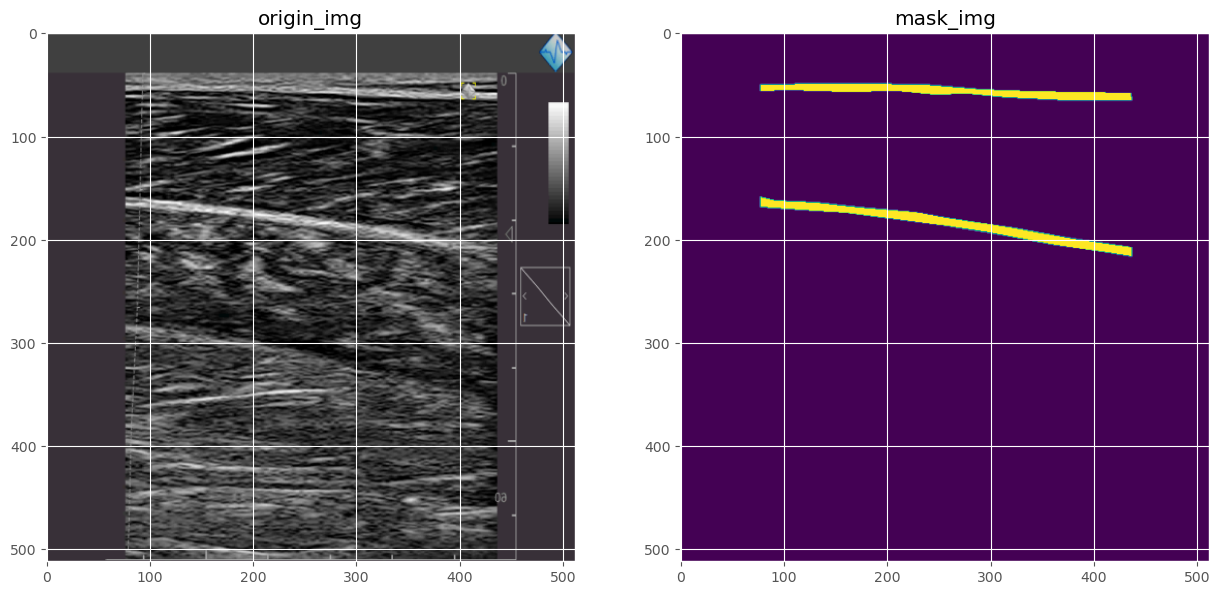

In [8]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = transforms.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

# 训练网络

In [9]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.n_classes
    else:
        n_classes = net.n_classes
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCELoss()
    dice_loss = smp.losses.DiceLoss(mode='binary')
   
    
    print("Validation round")
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)[0]
            dice_score += criterion(mask_pred, mask_true[0].float())
            dice_score += dice_loss((mask_pred > 0.5).float(), mask_true[0])
            
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true[0].long(), mode='binary', threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            
    print("Validation round IoU Score {}".format(iou_score / max(num_val_batches, 1)))
    return (dice_score / max(num_val_batches, 1), iou_score / max(num_val_batches, 1))

## 设置wandb账号
用作统计与数据分析

In [10]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland. Use `wandb login --relogin` to force relogin


In [11]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)


def train(model, device, 
          epochs: int = 60,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    if isinstance(model, nn.DataParallel):
        n_classes = model.module.n_classes
        n_channels = model.module.n_channels
    else:
        n_classes = model.n_classes
        n_channels = model.n_channels
        
    # (Initialize logging)
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')
    
     # Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#     optimizer = optim.RMSprop(model.parameters(),
#                               lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss() if n_classes > 1 else nn.BCELoss()
    dice_loss = smp.losses.DiceLoss(mode='binary')
#     iou_metric = smp.metrics.IoU(threshold=0.5),
    
    global_step = 0
    
#     iou_metric = IoU

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss((masks_pred > 0.5).float(), true_masks)

#                     iou = iou_metric(true_masks, (masks_pred > 0.5).float())
#                     if n_classes == 1:
#                         loss = criterion(masks_pred, true_masks.float())
#                         loss += dice_loss(F.sigmoid(masks_pred), true_masks.float(), multiclass=False)
#                     else:
                        
#                         loss = criterion(masks_pred, true_masks)
#                         loss += dice_loss(
#                             F.softmax(masks_pred, dim=1).float(),
#                             F.one_hot(true_masks, n_classes).permute(0, 3, 1, 2).float(),
#                             multiclass=True
#                         )
#                     iou = iou_metric(true_masks, (masks_pred > 0.5).float())
                    
                tp, fp, fn, tn = smp.metrics.get_stats(masks_pred[0], true_masks[0].long(), mode='binary', threshold=0.5)
                iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        model.train()
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(masks_pred[0].float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
            

if __name__ == '__main__':
    model = UNet(n_channels=3, n_classes=1, bilinear=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    model = model.to(memory_format=torch.channels_last)
    model.to(device)
    
    train(model, device)

    

Let's use 2 GPUs!


wandb: Currently logged in as: torwayland. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.15.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20231005_090611-e7f75ggm
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run feasible-aardvark-69
wandb: ⭐️ View project at https://wandb.ai/torwayland/U-Net
wandb: 🚀 View run at https://wandb.ai/torwayland/U-Net/runs/e7f75ggm
Epoch 1/60:  20%|█▉        | 90/456 [00:26<00:59,  6.20img/s, loss (batch)=1.55]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.49batch/s]


Validation round IoU Score 0.29059916734695435


Epoch 1/60:  39%|███▉      | 180/456 [00:55<00:47,  5.80img/s, loss (batch)=1.49]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.41batch/s]


Validation round IoU Score 0.23985537886619568


Epoch 1/60:  59%|█████▉    | 270/456 [01:24<00:31,  5.96img/s, loss (batch)=1.37]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.23batch/s]


Validation round IoU Score 0.370544970035553


Epoch 1/60:  79%|███████▉  | 360/456 [01:54<00:16,  5.82img/s, loss (batch)=1.26]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation round IoU Score 0.4930759072303772


Epoch 1/60:  99%|█████████▊| 450/456 [02:24<00:01,  5.66img/s, loss (batch)=1.24]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.5001417398452759


Epoch 2/60:  18%|█▊        | 84/456 [00:15<01:07,  5.53img/s, loss (batch)=1.31]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation round IoU Score 0.17431938648223877


Epoch 2/60:  38%|███▊      | 174/456 [00:45<00:48,  5.76img/s, loss (batch)=1.21]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation round IoU Score 0.5323827266693115


Epoch 2/60:  58%|█████▊    | 264/456 [01:15<00:34,  5.59img/s, loss (batch)=1.3] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.5355710983276367


Epoch 2/60:  78%|███████▊  | 354/456 [01:46<00:18,  5.65img/s, loss (batch)=1.24]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.5492607355117798


Epoch 2/60:  97%|█████████▋| 444/456 [02:16<00:02,  5.67img/s, loss (batch)=1.17]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation round IoU Score 0.4050503373146057


Epoch 3/60:  17%|█▋        | 78/456 [00:14<01:06,  5.72img/s, loss (batch)=1.21]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation round IoU Score 0.5676237940788269


Epoch 3/60:  37%|███▋      | 168/456 [00:44<00:51,  5.62img/s, loss (batch)=1.21]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation round IoU Score 0.562760591506958


Epoch 3/60:  57%|█████▋    | 258/456 [01:14<00:35,  5.51img/s, loss (batch)=1.22]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.5148980021476746


Epoch 3/60:  76%|███████▋  | 348/456 [01:44<00:20,  5.30img/s, loss (batch)=1.2] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation round IoU Score 0.5442318320274353


Epoch 3/60:  96%|█████████▌| 438/456 [02:15<00:03,  5.29img/s, loss (batch)=1.23]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.5639064908027649


Epoch 4/60:  16%|█▌        | 72/456 [00:12<01:07,  5.72img/s, loss (batch)=1.14]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation round IoU Score 0.5254923105239868


Epoch 4/60:  36%|███▌      | 162/456 [00:43<00:51,  5.68img/s, loss (batch)=1.2] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.5801700949668884


Epoch 4/60:  55%|█████▌    | 252/456 [01:13<00:36,  5.65img/s, loss (batch)=1.13]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation round IoU Score 0.530413806438446


Epoch 4/60:  75%|███████▌  | 342/456 [01:43<00:20,  5.63img/s, loss (batch)=1.19]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation round IoU Score 0.5625865459442139


Epoch 4/60:  95%|█████████▍| 432/456 [02:14<00:04,  5.51img/s, loss (batch)=1.35]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.3266785144805908


Epoch 5/60:  14%|█▍        | 66/456 [00:11<01:09,  5.61img/s, loss (batch)=1.19]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.560290515422821


Epoch 5/60:  34%|███▍      | 156/456 [00:41<00:53,  5.65img/s, loss (batch)=1.18]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation round IoU Score 0.516771137714386


Epoch 5/60:  54%|█████▍    | 246/456 [01:12<00:37,  5.54img/s, loss (batch)=1.21]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation round IoU Score 0.5304308533668518


Epoch 5/60:  74%|███████▎  | 336/456 [01:42<00:21,  5.63img/s, loss (batch)=1.17]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation round IoU Score 0.5260201096534729


Epoch 5/60:  93%|█████████▎| 426/456 [02:12<00:05,  5.58img/s, loss (batch)=1.22]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.3059585690498352


Epoch 6/60:  13%|█▎        | 60/456 [00:10<01:10,  5.63img/s, loss (batch)=1.17]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.49254852533340454


Epoch 6/60:  33%|███▎      | 150/456 [00:40<00:55,  5.51img/s, loss (batch)=1.2] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.3759995400905609


Epoch 6/60:  53%|█████▎    | 240/456 [01:11<00:38,  5.67img/s, loss (batch)=1.16]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.2727973461151123


Epoch 6/60:  72%|███████▏  | 330/456 [01:41<00:22,  5.63img/s, loss (batch)=1.13]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.6095507740974426


Epoch 6/60:  92%|█████████▏| 420/456 [02:11<00:06,  5.68img/s, loss (batch)=1.11]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.5585106015205383


Epoch 7/60:  12%|█▏        | 54/456 [00:10<01:10,  5.73img/s, loss (batch)=1.12]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation round IoU Score 0.5959048867225647


Epoch 7/60:  32%|███▏      | 144/456 [00:40<00:55,  5.61img/s, loss (batch)=1.14]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.6143155694007874


Epoch 7/60:  51%|█████▏    | 234/456 [01:10<00:39,  5.65img/s, loss (batch)=1.15]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.6013520359992981


Epoch 7/60:  71%|███████   | 324/456 [01:40<00:23,  5.59img/s, loss (batch)=1.16]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.5898070931434631


Epoch 7/60:  91%|█████████ | 414/456 [02:10<00:08,  5.22img/s, loss (batch)=1.11]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.613025963306427


Epoch 8/60:  11%|█         | 48/456 [00:08<01:11,  5.68img/s, loss (batch)=1.11]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation round IoU Score 0.614691436290741


Epoch 8/60:  30%|███       | 138/456 [00:39<00:56,  5.63img/s, loss (batch)=1.15]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation round IoU Score 0.6074262261390686


Epoch 8/60:  50%|█████     | 228/456 [01:09<00:40,  5.64img/s, loss (batch)=1.14]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation round IoU Score 0.5953541398048401


Epoch 8/60:  70%|██████▉   | 318/456 [01:39<00:24,  5.62img/s, loss (batch)=1.1] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation round IoU Score 0.31099164485931396


Epoch 8/60:  89%|████████▉ | 408/456 [02:09<00:08,  5.51img/s, loss (batch)=1.17]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.5858379602432251


Epoch 9/60:   9%|▉         | 42/456 [00:07<01:13,  5.61img/s, loss (batch)=1.11]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation round IoU Score 0.5267682671546936


Epoch 9/60:  29%|██▉       | 132/456 [00:37<00:57,  5.61img/s, loss (batch)=1.19]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.6268101930618286


Epoch 9/60:  49%|████▊     | 222/456 [01:07<00:41,  5.63img/s, loss (batch)=1.16]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation round IoU Score 0.619090735912323


Epoch 9/60:  68%|██████▊   | 312/456 [01:37<00:25,  5.68img/s, loss (batch)=1.11]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.6056700944900513


Epoch 9/60:  88%|████████▊ | 402/456 [02:08<00:09,  5.60img/s, loss (batch)=1.16]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation round IoU Score 0.5737589597702026


Epoch 10/60:   8%|▊         | 36/456 [00:06<01:13,  5.68img/s, loss (batch)=1.11]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.6114351153373718


Epoch 10/60:  28%|██▊       | 126/456 [00:36<01:00,  5.48img/s, loss (batch)=1.14]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation round IoU Score 0.6101411581039429


Epoch 10/60:  47%|████▋     | 216/456 [01:07<00:41,  5.72img/s, loss (batch)=1.1] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation round IoU Score 0.5821778178215027


Epoch 10/60:  67%|██████▋   | 306/456 [01:37<00:26,  5.61img/s, loss (batch)=1.15]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation round IoU Score 0.6270884275436401


Epoch 10/60:  87%|████████▋ | 396/456 [02:07<00:10,  5.67img/s, loss (batch)=1.11]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.5447813272476196


Epoch 11/60:   7%|▋         | 30/456 [00:05<01:13,  5.77img/s, loss (batch)=1.09]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.6262136697769165


Epoch 11/60:  26%|██▋       | 120/456 [00:35<00:59,  5.63img/s, loss (batch)=1.14]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.26145005226135254


Epoch 11/60:  46%|████▌     | 210/456 [01:06<00:43,  5.63img/s, loss (batch)=1.11]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.6278430819511414


Epoch 11/60:  66%|██████▌   | 300/456 [01:36<00:28,  5.47img/s, loss (batch)=1.13]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.5265073180198669


Epoch 11/60:  86%|████████▌ | 390/456 [02:06<00:12,  5.13img/s, loss (batch)=1.08]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation round IoU Score 0.5777435302734375


Epoch 12/60:   5%|▌         | 24/456 [00:04<01:26,  5.00img/s, loss (batch)=1.12]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation round IoU Score 0.6077567934989929


Epoch 12/60:  25%|██▌       | 114/456 [00:35<01:00,  5.67img/s, loss (batch)=1.12]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation round IoU Score 0.622943103313446


Epoch 12/60:  45%|████▍     | 204/456 [01:05<00:44,  5.62img/s, loss (batch)=1.13]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation round IoU Score 0.47295281291007996


Epoch 12/60:  64%|██████▍   | 294/456 [01:36<00:28,  5.63img/s, loss (batch)=1.09]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation round IoU Score 0.39217087626457214


Epoch 12/60:  84%|████████▍ | 384/456 [02:06<00:12,  5.58img/s, loss (batch)=1.11]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation round IoU Score 0.619638979434967


Epoch 13/60:   4%|▍         | 18/456 [00:03<01:16,  5.70img/s, loss (batch)=1.09]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation round IoU Score 0.6214302778244019


Epoch 13/60:  24%|██▎       | 108/456 [00:33<01:04,  5.43img/s, loss (batch)=1.1] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation round IoU Score 0.46550530195236206


Epoch 13/60:  43%|████▎     | 198/456 [01:03<00:45,  5.66img/s, loss (batch)=1.08]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.6036726832389832


Epoch 13/60:  63%|██████▎   | 288/456 [01:34<00:29,  5.61img/s, loss (batch)=1.11]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.5554094910621643


Epoch 13/60:  83%|████████▎ | 378/456 [02:04<00:13,  5.59img/s, loss (batch)=1.09]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation round IoU Score 0.6035346984863281


Epoch 14/60:   3%|▎         | 12/456 [00:02<01:17,  5.72img/s, loss (batch)=1.03]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.6431558132171631


Epoch 14/60:  22%|██▏       | 102/456 [00:32<01:03,  5.59img/s, loss (batch)=1.08]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation round IoU Score 0.5810872912406921


Epoch 14/60:  42%|████▏     | 192/456 [01:03<00:47,  5.59img/s, loss (batch)=1.09]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.6333386898040771


Epoch 14/60:  62%|██████▏   | 282/456 [01:33<00:30,  5.65img/s, loss (batch)=1.09]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.6479400396347046


Epoch 14/60:  82%|████████▏ | 372/456 [02:04<00:14,  5.70img/s, loss (batch)=1.07]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation round IoU Score 0.6091989874839783


Epoch 15/60:   1%|▏         | 6/456 [00:01<01:17,  5.78img/s, loss (batch)=1.13]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation round IoU Score 0.609764575958252


Epoch 15/60:  21%|██        | 96/456 [00:31<01:03,  5.66img/s, loss (batch)=1.13]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.5612736940383911


Epoch 15/60:  41%|████      | 186/456 [01:01<00:48,  5.61img/s, loss (batch)=1.08]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation round IoU Score 0.6129076480865479


Epoch 15/60:  61%|██████    | 276/456 [01:32<00:35,  5.05img/s, loss (batch)=1.08]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.6325478553771973


Epoch 15/60:  80%|████████  | 366/456 [02:03<00:15,  5.65img/s, loss (batch)=1.02]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.4826835095882416


Epoch 15/60: 100%|██████████| 456/456 [02:33<00:00,  5.47img/s, loss (batch)=1.05]

Validation round


Epoch 15/60: 100%|██████████| 456/456 [02:47<00:00,  2.72img/s, loss (batch)=1.05]


Validation round IoU Score 0.5836789011955261


Epoch 16/60:  20%|█▉        | 90/456 [00:16<01:08,  5.37img/s, loss (batch)=1.04]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation round IoU Score 0.6339557766914368


Epoch 16/60:  39%|███▉      | 180/456 [00:47<00:57,  4.83img/s, loss (batch)=1.05]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation round IoU Score 0.6274062991142273


Epoch 16/60:  59%|█████▉    | 270/456 [01:17<00:36,  5.15img/s, loss (batch)=1.13]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.5480440855026245


Epoch 16/60:  79%|███████▉  | 360/456 [01:48<00:17,  5.54img/s, loss (batch)=1.04]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation round IoU Score 0.6157655715942383


Epoch 16/60:  99%|█████████▊| 450/456 [02:19<00:01,  5.43img/s, loss (batch)=1.09]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation round IoU Score 0.5824923515319824


Epoch 17/60:  18%|█▊        | 84/456 [00:14<01:05,  5.64img/s, loss (batch)=1.07]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation round IoU Score 0.6406893134117126


Epoch 17/60:  38%|███▊      | 174/456 [00:45<00:50,  5.57img/s, loss (batch)=1.1] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation round IoU Score 0.624721109867096


Epoch 17/60:  58%|█████▊    | 264/456 [01:15<00:34,  5.63img/s, loss (batch)=1.04]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation round IoU Score 0.6255050897598267


Epoch 17/60:  78%|███████▊  | 354/456 [01:46<00:18,  5.65img/s, loss (batch)=1.07]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation round IoU Score 0.6238805055618286


Epoch 17/60:  97%|█████████▋| 444/456 [02:16<00:02,  5.64img/s, loss (batch)=1.08]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.6344913840293884


Epoch 18/60:  17%|█▋        | 78/456 [00:13<01:07,  5.63img/s, loss (batch)=1.06]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation round IoU Score 0.6018560528755188


Epoch 18/60:  37%|███▋      | 168/456 [00:44<00:52,  5.53img/s, loss (batch)=1.09]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.5900481343269348


Epoch 18/60:  57%|█████▋    | 258/456 [01:14<00:34,  5.77img/s, loss (batch)=1.02]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.6492292881011963


Epoch 18/60:  76%|███████▋  | 348/456 [01:44<00:19,  5.67img/s, loss (batch)=1.02]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation round IoU Score 0.630120575428009


Epoch 18/60:  96%|█████████▌| 438/456 [02:15<00:03,  5.63img/s, loss (batch)=1.04]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation round IoU Score 0.5468475818634033


Epoch 19/60:  16%|█▌        | 72/456 [00:12<01:08,  5.64img/s, loss (batch)=1.04]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation round IoU Score 0.5647739768028259


Epoch 19/60:  36%|███▌      | 162/456 [00:43<00:52,  5.62img/s, loss (batch)=1.04]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation round IoU Score 0.6342071890830994


Epoch 19/60:  55%|█████▌    | 252/456 [01:13<00:36,  5.59img/s, loss (batch)=1.1] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.5934708714485168


Epoch 19/60:  75%|███████▌  | 342/456 [01:43<00:20,  5.54img/s, loss (batch)=1.07]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.4186728596687317


Epoch 19/60:  95%|█████████▍| 432/456 [02:14<00:04,  5.63img/s, loss (batch)=1.07]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation round IoU Score 0.6282245516777039


Epoch 20/60:  14%|█▍        | 66/456 [00:12<01:08,  5.65img/s, loss (batch)=1.05]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.6051741242408752


Epoch 20/60:  34%|███▍      | 156/456 [00:42<00:54,  5.53img/s, loss (batch)=1.09]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.6179132461547852


Epoch 20/60:  54%|█████▍    | 246/456 [01:12<00:38,  5.52img/s, loss (batch)=1.04]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.5848680138587952


Epoch 20/60:  74%|███████▎  | 336/456 [01:43<00:22,  5.24img/s, loss (batch)=1.06]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.601677656173706


Epoch 20/60:  93%|█████████▎| 426/456 [02:13<00:05,  5.42img/s, loss (batch)=1.06]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation round IoU Score 0.5823548436164856


Epoch 21/60:  13%|█▎        | 60/456 [00:10<01:16,  5.19img/s, loss (batch)=1.01]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.5771194696426392


Epoch 21/60:  33%|███▎      | 150/456 [00:40<00:54,  5.66img/s, loss (batch)=1.01]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation round IoU Score 0.4814050793647766


Epoch 21/60:  53%|█████▎    | 240/456 [01:11<00:38,  5.66img/s, loss (batch)=1.02]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.5966920256614685


Epoch 21/60:  72%|███████▏  | 330/456 [01:42<00:22,  5.51img/s, loss (batch)=1.07]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation round IoU Score 0.5580947995185852


Epoch 21/60:  92%|█████████▏| 420/456 [02:12<00:06,  5.57img/s, loss (batch)=1.04] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation round IoU Score 0.6488003134727478


Epoch 22/60:  12%|█▏        | 54/456 [00:09<01:11,  5.62img/s, loss (batch)=1.04]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation round IoU Score 0.6301928162574768


Epoch 22/60:  32%|███▏      | 144/456 [00:39<00:56,  5.54img/s, loss (batch)=1.06]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation round IoU Score 0.6391547918319702


Epoch 22/60:  51%|█████▏    | 234/456 [01:10<00:40,  5.47img/s, loss (batch)=1.08]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation round IoU Score 0.5897616744041443


Epoch 22/60:  71%|███████   | 324/456 [01:40<00:23,  5.60img/s, loss (batch)=1.03]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.6472831964492798


Epoch 22/60:  91%|█████████ | 414/456 [02:10<00:07,  5.70img/s, loss (batch)=1.01]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation round IoU Score 0.5594601035118103


Epoch 23/60:  11%|█         | 48/456 [00:08<01:12,  5.59img/s, loss (batch)=1.05]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.6459251046180725


Epoch 23/60:  30%|███       | 138/456 [00:38<00:55,  5.72img/s, loss (batch)=1]   

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.6233619451522827


Epoch 23/60:  50%|█████     | 228/456 [01:09<00:39,  5.72img/s, loss (batch)=1.02] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.6344523429870605


Epoch 23/60:  70%|██████▉   | 318/456 [01:39<00:24,  5.57img/s, loss (batch)=1.03]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.588422954082489


Epoch 23/60:  89%|████████▉ | 408/456 [02:10<00:08,  5.50img/s, loss (batch)=1.05]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation round IoU Score 0.6182385087013245


Epoch 24/60:   9%|▉         | 42/456 [00:07<01:15,  5.52img/s, loss (batch)=1.07]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.5359282493591309


Epoch 24/60:  29%|██▉       | 132/456 [00:37<01:02,  5.22img/s, loss (batch)=1.02]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.6426281332969666


Epoch 24/60:  49%|████▊     | 222/456 [01:08<00:42,  5.55img/s, loss (batch)=1.05]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.5799813270568848


Epoch 24/60:  68%|██████▊   | 312/456 [01:38<00:25,  5.63img/s, loss (batch)=1.04]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation round IoU Score 0.6134012937545776


Epoch 24/60:  88%|████████▊ | 402/456 [02:09<00:09,  5.67img/s, loss (batch)=0.995]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.6162814497947693


Epoch 25/60:   8%|▊         | 36/456 [00:06<01:15,  5.58img/s, loss (batch)=1]   

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation round IoU Score 0.6474301218986511


Epoch 25/60:  28%|██▊       | 126/456 [00:36<01:00,  5.47img/s, loss (batch)=0.991]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation round IoU Score 0.6241883635520935


Epoch 25/60:  47%|████▋     | 216/456 [01:07<00:47,  5.07img/s, loss (batch)=1.07]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation round IoU Score 0.6119564175605774


Epoch 25/60:  67%|██████▋   | 306/456 [01:37<00:26,  5.59img/s, loss (batch)=1.03]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.6333382725715637


Epoch 25/60:  87%|████████▋ | 396/456 [02:08<00:10,  5.61img/s, loss (batch)=0.995]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation round IoU Score 0.6536614894866943


Epoch 26/60:   7%|▋         | 30/456 [00:05<01:14,  5.71img/s, loss (batch)=0.989]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.5986382365226746


Epoch 26/60:  26%|██▋       | 120/456 [00:35<01:00,  5.56img/s, loss (batch)=1.02]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.5656386017799377


Epoch 26/60:  46%|████▌     | 210/456 [01:06<00:44,  5.50img/s, loss (batch)=1.09]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.5445582270622253


Epoch 26/60:  66%|██████▌   | 300/456 [01:36<00:27,  5.60img/s, loss (batch)=0.973]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation round IoU Score 0.6082853674888611


Epoch 26/60:  86%|████████▌ | 390/456 [02:06<00:11,  5.59img/s, loss (batch)=1.01]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.6308414936065674


Epoch 27/60:   5%|▌         | 24/456 [00:04<01:17,  5.56img/s, loss (batch)=1.03]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.5583999752998352


Epoch 27/60:  25%|██▌       | 114/456 [00:34<01:04,  5.32img/s, loss (batch)=1.01]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.4755580723285675


Epoch 27/60:  45%|████▍     | 204/456 [01:04<00:45,  5.49img/s, loss (batch)=0.987]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation round IoU Score 0.6228326559066772


Epoch 27/60:  64%|██████▍   | 294/456 [01:35<00:29,  5.56img/s, loss (batch)=1.06] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.5722981095314026


Epoch 27/60:  84%|████████▍ | 384/456 [02:06<00:12,  5.56img/s, loss (batch)=1.02]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation round IoU Score 0.6201390624046326


Epoch 28/60:   4%|▍         | 18/456 [00:03<01:18,  5.57img/s, loss (batch)=1.08] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation round IoU Score 0.5921362638473511


Epoch 28/60:  24%|██▎       | 108/456 [00:33<01:01,  5.65img/s, loss (batch)=0.992]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation round IoU Score 0.5852708220481873


Epoch 28/60:  43%|████▎     | 198/456 [01:03<00:46,  5.55img/s, loss (batch)=1.08] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation round IoU Score 0.5704160928726196


Epoch 28/60:  63%|██████▎   | 288/456 [01:34<00:30,  5.58img/s, loss (batch)=1.07]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation round IoU Score 0.6239351630210876


Epoch 28/60:  83%|████████▎ | 378/456 [02:04<00:13,  5.63img/s, loss (batch)=1.01] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation round IoU Score 0.6173132061958313


Epoch 29/60:   3%|▎         | 12/456 [00:02<01:19,  5.59img/s, loss (batch)=0.994]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.635411262512207


Epoch 29/60:  22%|██▏       | 102/456 [00:32<01:03,  5.54img/s, loss (batch)=1.04]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.6400142908096313


Epoch 29/60:  42%|████▏     | 192/456 [01:02<00:46,  5.64img/s, loss (batch)=0.991]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.6396811604499817


Epoch 29/60:  62%|██████▏   | 282/456 [01:33<00:31,  5.60img/s, loss (batch)=1]   

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.6248617768287659


Epoch 29/60:  82%|████████▏ | 372/456 [02:03<00:15,  5.41img/s, loss (batch)=1.03] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.61761873960495


Epoch 30/60:   1%|▏         | 6/456 [00:01<01:26,  5.18img/s, loss (batch)=1.01]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.6054037809371948


Epoch 30/60:  21%|██        | 96/456 [00:31<01:08,  5.29img/s, loss (batch)=1.02]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.5709435939788818


Epoch 30/60:  41%|████      | 186/456 [01:02<00:56,  4.82img/s, loss (batch)=1.01]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation round IoU Score 0.577322781085968


Epoch 30/60:  61%|██████    | 276/456 [01:33<00:31,  5.66img/s, loss (batch)=1.03]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation round IoU Score 0.6306381821632385


Epoch 30/60:  80%|████████  | 366/456 [02:03<00:15,  5.63img/s, loss (batch)=0.993]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation round IoU Score 0.6524754166603088


Epoch 30/60: 100%|██████████| 456/456 [02:34<00:00,  5.61img/s, loss (batch)=0.985]

Validation round


Epoch 30/60: 100%|██████████| 456/456 [02:48<00:00,  2.71img/s, loss (batch)=0.985]


Validation round IoU Score 0.6409692168235779


Epoch 31/60:  20%|█▉        | 90/456 [00:15<01:03,  5.76img/s, loss (batch)=0.948]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation round IoU Score 0.6501931548118591


Epoch 31/60:  39%|███▉      | 180/456 [00:46<00:49,  5.52img/s, loss (batch)=0.999]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.5868094563484192


Epoch 31/60:  59%|█████▉    | 270/456 [01:16<00:33,  5.52img/s, loss (batch)=1.03]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.6217136979103088


Epoch 31/60:  79%|███████▉  | 360/456 [01:47<00:17,  5.60img/s, loss (batch)=0.996]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation round IoU Score 0.5037369132041931


Epoch 31/60:  99%|█████████▊| 450/456 [02:17<00:01,  5.55img/s, loss (batch)=1.02]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.48186224699020386


Epoch 32/60:  18%|█▊        | 84/456 [00:15<01:06,  5.57img/s, loss (batch)=1.08] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.6155998110771179


Epoch 32/60:  38%|███▊      | 174/456 [00:45<00:50,  5.60img/s, loss (batch)=1.03] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation round IoU Score 0.6214236617088318


Epoch 32/60:  58%|█████▊    | 264/456 [01:16<00:35,  5.37img/s, loss (batch)=0.966]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.5273138880729675


Epoch 32/60:  78%|███████▊  | 354/456 [01:46<00:18,  5.55img/s, loss (batch)=0.999]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation round IoU Score 0.6329097151756287


Epoch 32/60:  97%|█████████▋| 444/456 [02:17<00:02,  5.68img/s, loss (batch)=0.954]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation round IoU Score 0.6349265575408936


Epoch 33/60:  17%|█▋        | 78/456 [00:14<01:06,  5.67img/s, loss (batch)=0.992]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.6159704923629761


Epoch 33/60:  37%|███▋      | 168/456 [00:44<00:50,  5.70img/s, loss (batch)=0.957]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation round IoU Score 0.6260826587677002


Epoch 33/60:  57%|█████▋    | 258/456 [01:14<00:35,  5.62img/s, loss (batch)=0.97] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation round IoU Score 0.6170486807823181


Epoch 33/60:  76%|███████▋  | 348/456 [01:45<00:19,  5.57img/s, loss (batch)=1.01] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.6262360215187073


Epoch 33/60:  96%|█████████▌| 438/456 [02:16<00:03,  5.05img/s, loss (batch)=0.996]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.6056153178215027


Epoch 34/60:  16%|█▌        | 72/456 [00:13<01:09,  5.51img/s, loss (batch)=1]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation round IoU Score 0.42702716588974


Epoch 34/60:  36%|███▌      | 162/456 [00:43<00:51,  5.66img/s, loss (batch)=0.964]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.6473463773727417


Epoch 34/60:  55%|█████▌    | 252/456 [01:13<00:36,  5.57img/s, loss (batch)=0.99] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation round IoU Score 0.6535793542861938


Epoch 34/60:  75%|███████▌  | 342/456 [01:44<00:22,  5.13img/s, loss (batch)=1.01] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.602329432964325


Epoch 34/60:  95%|█████████▍| 432/456 [02:14<00:04,  5.34img/s, loss (batch)=1.07]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.02batch/s]


Validation round IoU Score 0.5329757332801819


Epoch 35/60:  14%|█▍        | 66/456 [00:11<01:16,  5.09img/s, loss (batch)=1.04] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation round IoU Score 0.6291109323501587


Epoch 35/60:  34%|███▍      | 156/456 [00:42<00:53,  5.66img/s, loss (batch)=0.917]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation round IoU Score 0.6226051449775696


Epoch 35/60:  54%|█████▍    | 246/456 [01:13<00:37,  5.55img/s, loss (batch)=0.988]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation round IoU Score 0.6286665797233582


Epoch 35/60:  74%|███████▎  | 336/456 [01:44<00:21,  5.59img/s, loss (batch)=1]    

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation round IoU Score 0.5888656377792358


Epoch 35/60:  93%|█████████▎| 426/456 [02:14<00:05,  5.50img/s, loss (batch)=1.03] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation round IoU Score 0.6437897086143494


Epoch 36/60:  13%|█▎        | 60/456 [00:10<01:10,  5.64img/s, loss (batch)=1.06]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.5588232278823853


Epoch 36/60:  33%|███▎      | 150/456 [00:41<00:54,  5.65img/s, loss (batch)=0.955]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.5929528474807739


Epoch 36/60:  53%|█████▎    | 240/456 [01:11<00:38,  5.60img/s, loss (batch)=1.02] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.6082823276519775


Epoch 36/60:  72%|███████▏  | 330/456 [01:41<00:22,  5.66img/s, loss (batch)=0.991]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.97batch/s]


Validation round IoU Score 0.6101616621017456


Epoch 36/60:  92%|█████████▏| 420/456 [02:12<00:06,  5.57img/s, loss (batch)=0.978]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.5862333178520203


Epoch 37/60:  12%|█▏        | 54/456 [00:09<01:12,  5.52img/s, loss (batch)=0.988]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.6429769992828369


Epoch 37/60:  32%|███▏      | 144/456 [00:40<01:00,  5.19img/s, loss (batch)=0.962]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.09batch/s]


Validation round IoU Score 0.6062726378440857


Epoch 37/60:  51%|█████▏    | 234/456 [01:10<00:40,  5.52img/s, loss (batch)=0.998]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation round IoU Score 0.6167012453079224


Epoch 37/60:  71%|███████   | 324/456 [01:41<00:23,  5.60img/s, loss (batch)=1.01] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.5416557192802429


Epoch 37/60:  91%|█████████ | 414/456 [02:11<00:07,  5.60img/s, loss (batch)=0.974]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation round IoU Score 0.4684314429759979


Epoch 38/60:  11%|█         | 48/456 [00:08<01:12,  5.60img/s, loss (batch)=1.02] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.5149223208427429


Epoch 38/60:  30%|███       | 138/456 [00:38<00:56,  5.60img/s, loss (batch)=1.01] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.6346344947814941


Epoch 38/60:  50%|█████     | 228/456 [01:09<00:40,  5.68img/s, loss (batch)=0.991]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.5713767409324646


Epoch 38/60:  70%|██████▉   | 318/456 [01:40<00:24,  5.67img/s, loss (batch)=0.964]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.06batch/s]


Validation round IoU Score 0.5722669959068298


Epoch 38/60:  89%|████████▉ | 408/456 [02:10<00:08,  5.58img/s, loss (batch)=1.02] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.6144362092018127


Epoch 39/60:   9%|▉         | 42/456 [00:07<01:13,  5.62img/s, loss (batch)=1.02] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation round IoU Score 0.6363364458084106


Epoch 39/60:  29%|██▉       | 132/456 [00:38<01:01,  5.23img/s, loss (batch)=0.996]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation round IoU Score 0.6232448816299438


Epoch 39/60:  49%|████▊     | 222/456 [01:08<00:49,  4.71img/s, loss (batch)=1.01] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.5278692245483398


Epoch 39/60:  68%|██████▊   | 312/456 [01:39<00:25,  5.56img/s, loss (batch)=0.943]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation round IoU Score 0.6101579666137695


Epoch 39/60:  88%|████████▊ | 402/456 [02:10<00:09,  5.61img/s, loss (batch)=0.977]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation round IoU Score 0.5461036562919617


Epoch 40/60:   8%|▊         | 36/456 [00:06<01:15,  5.55img/s, loss (batch)=0.966]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation round IoU Score 0.5691556334495544


Epoch 40/60:  28%|██▊       | 126/456 [00:36<00:57,  5.72img/s, loss (batch)=0.961]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation round IoU Score 0.6323869228363037


Epoch 40/60:  47%|████▋     | 216/456 [01:07<00:43,  5.52img/s, loss (batch)=0.984]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation round IoU Score 0.6418202519416809


Epoch 40/60:  67%|██████▋   | 306/456 [01:37<00:26,  5.63img/s, loss (batch)=0.932]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation round IoU Score 0.6117920279502869


Epoch 40/60:  87%|████████▋ | 396/456 [02:08<00:10,  5.76img/s, loss (batch)=0.97] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation round IoU Score 0.4588979184627533


Epoch 41/60:   7%|▋         | 30/456 [00:05<01:15,  5.62img/s, loss (batch)=0.961]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.6009148955345154


Epoch 41/60:  26%|██▋       | 120/456 [00:35<01:00,  5.55img/s, loss (batch)=0.968]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.6515138149261475


Epoch 41/60:  46%|████▌     | 210/456 [01:05<00:45,  5.43img/s, loss (batch)=0.978]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation round IoU Score 0.6436723470687866


Epoch 41/60:  66%|██████▌   | 300/456 [01:36<00:27,  5.62img/s, loss (batch)=1]    

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation round IoU Score 0.6335673332214355


Epoch 41/60:  86%|████████▌ | 390/456 [02:06<00:11,  5.61img/s, loss (batch)=0.964]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation round IoU Score 0.6275491118431091


Epoch 42/60:   5%|▌         | 24/456 [00:04<01:17,  5.60img/s, loss (batch)=0.982]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation round IoU Score 0.5183131098747253


Epoch 42/60:  25%|██▌       | 114/456 [00:34<01:00,  5.61img/s, loss (batch)=0.977]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.6379221677780151


Epoch 42/60:  45%|████▍     | 204/456 [01:05<00:44,  5.62img/s, loss (batch)=0.99] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation round IoU Score 0.5931167602539062


Epoch 42/60:  64%|██████▍   | 294/456 [01:35<00:28,  5.71img/s, loss (batch)=0.935]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation round IoU Score 0.6158026456832886


Epoch 42/60:  84%|████████▍ | 384/456 [02:06<00:12,  5.58img/s, loss (batch)=1.04] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation round IoU Score 0.6094990372657776


Epoch 43/60:   4%|▍         | 18/456 [00:03<01:16,  5.70img/s, loss (batch)=0.959]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation round IoU Score 0.6270511746406555


Epoch 43/60:  24%|██▎       | 108/456 [00:33<01:06,  5.23img/s, loss (batch)=1.02] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.6284117698669434


Epoch 43/60:  43%|████▎     | 198/456 [01:04<00:46,  5.59img/s, loss (batch)=0.969]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation round IoU Score 0.6380202174186707


Epoch 43/60:  63%|██████▎   | 288/456 [01:34<00:30,  5.50img/s, loss (batch)=1.04]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation round IoU Score 0.4708908200263977


Epoch 43/60:  83%|████████▎ | 378/456 [02:05<00:13,  5.70img/s, loss (batch)=0.927]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.6409428715705872


Epoch 44/60:   3%|▎         | 12/456 [00:02<01:21,  5.43img/s, loss (batch)=0.958]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.34554433822631836


Epoch 44/60:  22%|██▏       | 102/456 [00:32<01:06,  5.35img/s, loss (batch)=0.955]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.08batch/s]


Validation round IoU Score 0.6365653276443481


Epoch 44/60:  42%|████▏     | 192/456 [01:03<00:48,  5.41img/s, loss (batch)=0.968]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.6114344596862793


Epoch 44/60:  62%|██████▏   | 282/456 [01:33<00:31,  5.57img/s, loss (batch)=0.96] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation round IoU Score 0.5840376019477844


Epoch 44/60:  82%|████████▏ | 372/456 [02:04<00:14,  5.74img/s, loss (batch)=0.948]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation round IoU Score 0.6308081150054932


Epoch 45/60:   1%|▏         | 6/456 [00:01<01:24,  5.31img/s, loss (batch)=0.988]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.5847004652023315


Epoch 45/60:  21%|██        | 96/456 [00:31<01:05,  5.47img/s, loss (batch)=0.907]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation round IoU Score 0.5777151584625244


Epoch 45/60:  41%|████      | 186/456 [01:02<00:49,  5.51img/s, loss (batch)=0.95] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.61batch/s]


Validation round IoU Score 0.532735288143158


Epoch 45/60:  61%|██████    | 276/456 [01:32<00:31,  5.70img/s, loss (batch)=0.921]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation round IoU Score 0.5903738737106323


Epoch 45/60:  80%|████████  | 366/456 [02:03<00:15,  5.63img/s, loss (batch)=0.956]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation round IoU Score 0.5617988705635071


Epoch 45/60: 100%|██████████| 456/456 [02:33<00:00,  5.70img/s, loss (batch)=0.974]

Validation round


Epoch 45/60: 100%|██████████| 456/456 [02:48<00:00,  2.71img/s, loss (batch)=0.974]


Validation round IoU Score 0.623522937297821


Epoch 46/60:  20%|█▉        | 90/456 [00:16<01:07,  5.40img/s, loss (batch)=0.982]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.5145297646522522


Epoch 46/60:  39%|███▉      | 180/456 [00:47<00:50,  5.48img/s, loss (batch)=0.977]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation round IoU Score 0.6338418126106262


Epoch 46/60:  59%|█████▉    | 270/456 [01:17<00:33,  5.58img/s, loss (batch)=0.95]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.96batch/s]


Validation round IoU Score 0.6058242321014404


Epoch 46/60:  79%|███████▉  | 360/456 [01:48<00:18,  5.10img/s, loss (batch)=0.983]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.6010026931762695


Epoch 46/60:  99%|█████████▊| 450/456 [02:18<00:01,  5.71img/s, loss (batch)=0.923]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation round IoU Score 0.5737853646278381


Epoch 47/60:  18%|█▊        | 84/456 [00:15<01:05,  5.68img/s, loss (batch)=0.953]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation round IoU Score 0.6217387914657593


Epoch 47/60:  38%|███▊      | 174/456 [00:45<00:50,  5.63img/s, loss (batch)=0.936]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation round IoU Score 0.6168555021286011


Epoch 47/60:  58%|█████▊    | 264/456 [01:16<00:34,  5.61img/s, loss (batch)=0.943]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation round IoU Score 0.6405876278877258


Epoch 47/60:  78%|███████▊  | 354/456 [01:46<00:17,  5.72img/s, loss (batch)=0.922]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation round IoU Score 0.5919967889785767


Epoch 47/60:  97%|█████████▋| 444/456 [02:17<00:02,  5.56img/s, loss (batch)=0.964]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.6342368721961975


Epoch 48/60:  17%|█▋        | 78/456 [00:14<01:05,  5.76img/s, loss (batch)=0.924]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.07batch/s]


Validation round IoU Score 0.6477785110473633


Epoch 48/60:  37%|███▋      | 168/456 [00:45<00:51,  5.59img/s, loss (batch)=0.965]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.05batch/s]


Validation round IoU Score 0.6302675604820251


Epoch 48/60:  57%|█████▋    | 258/456 [01:15<00:39,  5.07img/s, loss (batch)=0.956]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.04batch/s]


Validation round IoU Score 0.6455038189888


Epoch 48/60:  76%|███████▋  | 348/456 [01:46<00:18,  5.71img/s, loss (batch)=0.918]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation round IoU Score 0.601175844669342


Epoch 48/60:  96%|█████████▌| 438/456 [02:16<00:03,  5.59img/s, loss (batch)=0.9]  

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation round IoU Score 0.6370143890380859


Epoch 49/60:  16%|█▌        | 72/456 [00:12<01:10,  5.46img/s, loss (batch)=0.967]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation round IoU Score 0.6232781410217285


Epoch 49/60:  36%|███▌      | 162/456 [00:43<00:55,  5.30img/s, loss (batch)=1.01] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation round IoU Score 0.5525854229927063


Epoch 49/60:  55%|█████▌    | 252/456 [01:14<00:37,  5.40img/s, loss (batch)=0.935]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.5812655091285706


Epoch 49/60:  75%|███████▌  | 342/456 [01:44<00:20,  5.63img/s, loss (batch)=0.983]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.5795373916625977


Epoch 49/60:  95%|█████████▍| 432/456 [02:15<00:04,  5.62img/s, loss (batch)=0.989]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.6615023612976074


Epoch 50/60:  14%|█▍        | 66/456 [00:12<01:10,  5.54img/s, loss (batch)=0.923]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation round IoU Score 0.6325669288635254


Epoch 50/60:  34%|███▍      | 156/456 [00:42<00:57,  5.23img/s, loss (batch)=0.935]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation round IoU Score 0.6381237506866455


Epoch 50/60:  54%|█████▍    | 246/456 [01:13<00:37,  5.65img/s, loss (batch)=0.948]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.55batch/s]


Validation round IoU Score 0.6381121277809143


Epoch 50/60:  74%|███████▎  | 336/456 [01:44<00:21,  5.52img/s, loss (batch)=0.942]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.68batch/s]


Validation round IoU Score 0.6403863430023193


Epoch 50/60:  93%|█████████▎| 426/456 [02:14<00:05,  5.49img/s, loss (batch)=0.976]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation round IoU Score 0.6135249733924866


Epoch 51/60:  13%|█▎        | 60/456 [00:10<01:08,  5.77img/s, loss (batch)=0.911]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.6033269166946411


Epoch 51/60:  33%|███▎      | 150/456 [00:41<00:55,  5.54img/s, loss (batch)=0.929]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation round IoU Score 0.6436256170272827


Epoch 51/60:  53%|█████▎    | 240/456 [01:12<00:39,  5.46img/s, loss (batch)=0.914]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation round IoU Score 0.5875613689422607


Epoch 51/60:  72%|███████▏  | 330/456 [01:43<00:22,  5.63img/s, loss (batch)=0.992]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation round IoU Score 0.5759244561195374


Epoch 51/60:  92%|█████████▏| 420/456 [02:15<00:07,  4.89img/s, loss (batch)=0.973]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation round IoU Score 0.2875758409500122


Epoch 52/60:  12%|█▏        | 54/456 [00:09<01:10,  5.66img/s, loss (batch)=0.923]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.56batch/s]


Validation round IoU Score 0.6349371671676636


Epoch 52/60:  32%|███▏      | 144/456 [00:40<00:55,  5.65img/s, loss (batch)=0.966]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.50batch/s]


Validation round IoU Score 0.5764531493186951


Epoch 52/60:  51%|█████▏    | 234/456 [01:11<00:40,  5.42img/s, loss (batch)=0.961]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.36batch/s]


Validation round IoU Score 0.49165356159210205


Epoch 52/60:  71%|███████   | 324/456 [01:43<00:23,  5.65img/s, loss (batch)=0.96] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation round IoU Score 0.6020188927650452


Epoch 52/60:  91%|█████████ | 414/456 [02:14<00:07,  5.44img/s, loss (batch)=0.953]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation round IoU Score 0.5164691805839539


Epoch 53/60:  11%|█         | 48/456 [00:08<01:13,  5.54img/s, loss (batch)=0.965]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.98batch/s]


Validation round IoU Score 0.6060113310813904


Epoch 53/60:  30%|███       | 138/456 [00:39<00:57,  5.56img/s, loss (batch)=0.931]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation round IoU Score 0.6117918491363525


Epoch 53/60:  50%|█████     | 228/456 [01:10<00:45,  4.99img/s, loss (batch)=0.962]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation round IoU Score 0.549717903137207


Epoch 53/60:  70%|██████▉   | 318/456 [01:40<00:24,  5.62img/s, loss (batch)=0.912]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation round IoU Score 0.5885657668113708


Epoch 53/60:  89%|████████▉ | 408/456 [02:11<00:08,  5.69img/s, loss (batch)=0.909]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation round IoU Score 0.5875434279441833


Epoch 54/60:   9%|▉         | 42/456 [00:07<01:17,  5.33img/s, loss (batch)=0.918]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation round IoU Score 0.6302828192710876


Epoch 54/60:  29%|██▉       | 132/456 [00:38<00:57,  5.63img/s, loss (batch)=0.932]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.99batch/s]


Validation round IoU Score 0.6631830334663391


Epoch 54/60:  49%|████▊     | 222/456 [01:09<00:42,  5.44img/s, loss (batch)=0.956]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.6257470846176147


Epoch 54/60:  68%|██████▊   | 312/456 [01:39<00:25,  5.60img/s, loss (batch)=0.932]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.5363501906394958


Epoch 54/60:  88%|████████▊ | 402/456 [02:10<00:09,  5.56img/s, loss (batch)=0.951]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation round IoU Score 0.6403639912605286


Epoch 55/60:   8%|▊         | 36/456 [00:06<01:21,  5.13img/s, loss (batch)=0.95] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.00batch/s]


Validation round IoU Score 0.6588483452796936


Epoch 55/60:  28%|██▊       | 126/456 [00:37<01:00,  5.43img/s, loss (batch)=0.948]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation round IoU Score 0.6594591736793518


Epoch 55/60:  47%|████▋     | 216/456 [01:08<00:44,  5.34img/s, loss (batch)=0.952]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation round IoU Score 0.6439497470855713


Epoch 55/60:  67%|██████▋   | 306/456 [01:39<00:29,  5.16img/s, loss (batch)=0.937]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation round IoU Score 0.6446002125740051


Epoch 55/60:  87%|████████▋ | 396/456 [02:09<00:11,  5.32img/s, loss (batch)=0.932]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.03batch/s]


Validation round IoU Score 0.57485032081604


Epoch 56/60:   7%|▋         | 30/456 [00:05<01:15,  5.66img/s, loss (batch)=0.903]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation round IoU Score 0.6413496732711792


Epoch 56/60:  26%|██▋       | 120/456 [00:36<01:00,  5.53img/s, loss (batch)=0.962]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.6505553722381592


Epoch 56/60:  46%|████▌     | 210/456 [01:07<00:44,  5.56img/s, loss (batch)=0.94] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation round IoU Score 0.6366842985153198


Epoch 56/60:  66%|██████▌   | 300/456 [01:38<00:30,  5.12img/s, loss (batch)=0.943]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation round IoU Score 0.4896688759326935


Epoch 56/60:  86%|████████▌ | 390/456 [02:09<00:11,  5.62img/s, loss (batch)=0.946]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.38batch/s]


Validation round IoU Score 0.5871714949607849


Epoch 57/60:   5%|▌         | 24/456 [00:04<01:17,  5.55img/s, loss (batch)=0.913]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.57batch/s]


Validation round IoU Score 0.5954895615577698


Epoch 57/60:  25%|██▌       | 114/456 [00:35<01:02,  5.50img/s, loss (batch)=0.908]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.62batch/s]


Validation round IoU Score 0.5945636034011841


Epoch 57/60:  45%|████▍     | 204/456 [01:06<00:44,  5.68img/s, loss (batch)=0.921]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation round IoU Score 0.6480098962783813


Epoch 57/60:  64%|██████▍   | 294/456 [01:37<00:29,  5.57img/s, loss (batch)=0.939]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation round IoU Score 0.42655524611473083


Epoch 57/60:  84%|████████▍ | 384/456 [02:08<00:12,  5.61img/s, loss (batch)=0.935]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation round IoU Score 0.6657745242118835


Epoch 58/60:   4%|▍         | 18/456 [00:03<01:19,  5.53img/s, loss (batch)=0.935]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.85batch/s]


Validation round IoU Score 0.5692422389984131


Epoch 58/60:  24%|██▎       | 108/456 [00:34<01:09,  5.00img/s, loss (batch)=0.985]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation round IoU Score 0.6279260516166687


Epoch 58/60:  43%|████▎     | 198/456 [01:05<00:45,  5.63img/s, loss (batch)=0.904]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.53batch/s]


Validation round IoU Score 0.5928070545196533


Epoch 58/60:  63%|██████▎   | 288/456 [01:36<00:30,  5.55img/s, loss (batch)=0.981]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.40batch/s]


Validation round IoU Score 0.5955023169517517


Epoch 58/60:  83%|████████▎ | 378/456 [02:07<00:14,  5.56img/s, loss (batch)=0.905]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation round IoU Score 0.6332169771194458


Epoch 59/60:   3%|▎         | 12/456 [00:02<01:20,  5.50img/s, loss (batch)=0.935]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation round IoU Score 0.5913439989089966


Epoch 59/60:  22%|██▏       | 102/456 [00:33<01:04,  5.53img/s, loss (batch)=0.944]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation round IoU Score 0.6157994270324707


Epoch 59/60:  42%|████▏     | 192/456 [01:04<00:48,  5.44img/s, loss (batch)=0.934]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation round IoU Score 0.5735321044921875


Epoch 59/60:  62%|██████▏   | 282/456 [01:35<00:34,  5.09img/s, loss (batch)=0.939]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation round IoU Score 0.6075340509414673


Epoch 59/60:  82%|████████▏ | 372/456 [02:06<00:15,  5.52img/s, loss (batch)=0.939]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.56batch/s]


Validation round IoU Score 0.5984861254692078


Epoch 60/60:   1%|▏         | 6/456 [00:01<01:21,  5.50img/s, loss (batch)=0.955]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation round IoU Score 0.5646798610687256


Epoch 60/60:  21%|██        | 96/456 [00:32<01:04,  5.57img/s, loss (batch)=0.935]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.67batch/s]


Validation round IoU Score 0.6468313932418823


Epoch 60/60:  41%|████      | 186/456 [01:03<00:47,  5.67img/s, loss (batch)=0.923]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation round IoU Score 0.6526830792427063


Epoch 60/60:  61%|██████    | 276/456 [01:34<00:32,  5.62img/s, loss (batch)=0.949]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.5992194414138794


Epoch 60/60:  80%|████████  | 366/456 [02:05<00:16,  5.39img/s, loss (batch)=0.924]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation round IoU Score 0.6360476016998291


Epoch 60/60: 100%|██████████| 456/456 [02:37<00:00,  5.29img/s, loss (batch)=0.911]

Validation round


Epoch 60/60: 100%|██████████| 456/456 [02:51<00:00,  2.66img/s, loss (batch)=0.911]

Validation round IoU Score 0.6419417858123779


# 推理